For this week's assignment I reimplemented the online TD($\lambda$) experiment from the RL book (Sutton). 

The domain is a 19 state corridor in which there are only two actions [left, right]. The episode terminates once the agent reaches one of the two extreme sides of the corridor. The agent receives a +1 reward if it reaches the right side of the corridor, otherwise a 0 reward is obtained at every time step. 

Just like in the RL book, I consider the prediction problem. That is, to predict the proper value at every state encountered by the agent. Since the samples are being generated by a random walk, the value for each state corresponds to -- (state_index + 1) / (19 + 1); which can be seen as the probability of reaching the right hand side of the maze from the given state.  

I implemented online TD($\lambda$) and ran the experiment with several values of $\lambda$ and $\alpha$.

In [1]:
class Corridor(object):
    def __init__(self, num_states=19):
        self.num_states = num_states
        self.state_shape = [num_states]
        self.nb_actions = 2
        self.state = np.zeros(num_states, dtype='float32')
        self.start_pos = int(num_states / 2)
        self.pos = self.start_pos
        self.counter = 0

    def observe(self):
        return np.copy(self.state)

    def _is_over(self):
        # exit or max number of steps
        return self.pos == -1 or self.pos == self.num_states

    def _update_state(self, action):
        if action == 0 and self.pos == 0:
            self.state = np.zeros(self.num_states, dtype='float32')
            self.pos -= 1
        elif action == 1 and self.pos == self.num_states - 1:
            self.state = np.zeros(self.num_states, dtype='float32')
            self.pos += 1
        elif action == 0:  # move left
            self.state = np.zeros(self.num_states, dtype='float32')
            self.state[self.pos - 1] = 1
            self.pos -= 1
        elif action == 1:  # move right
            self.state = np.zeros(self.num_states, dtype='float32')
            self.state[self.pos + 1] = 1
            self.pos += 1

    def _get_reward(self):
        if self.pos == self.num_states:
            reward = 1.0
        else:
            reward = 0.0
        return reward

    def act(self, action):
        assert action == 0 or action == 1 or action == 2
        self._update_state(action)
        reward = self._get_reward()
        game_over = self._is_over()
        self.counter += 1
        # #
        return np.copy(self.state), reward, game_over

    def reset(self):
        self.state = np.zeros(self.num_states, dtype='float32')
        self.state[self.start_pos] = 1
        self.pos = self.start_pos
        self.counter = 0

In [2]:
import numpy as np


class Agent(object):
    def __init__(self, state_shape, nb_actions, gamma=1.0, lambd=0.0, lr=0.1, init=0):
        self.state_shape = state_shape
        self.nb_actions = nb_actions
        self.gamma = gamma
        self.lambd = lambd
        self.lr = lr
        self.init = init
        self.e_t = np.zeros(self.state_shape)
        self.theta = np.ones(self.state_shape) * init

    def predict(self, phi):
        return np.dot(self.theta, phi)

    def learn(self, s, a, r, s2, t):
        pred = self.predict(s)
        target = r + (1 - t) * self.gamma * self.predict(s2)
        self.e_t = s + self.gamma * self.lambd * self.e_t
        self.theta += self.lr * (target - pred) * self.e_t

    def reset_trace(self):
        self.e_t = np.zeros(self.state_shape)
    
    def reset(self):
        self.e_t = np.zeros(self.state_shape)
        self.theta = np.ones(self.state_shape) * self.init

In [3]:
import numpy as np
import pickle


nb_episodes = 10
lambdas = [0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.975, 0.99, 1]
alphas = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
env = Corridor(num_states=19)
all_agent_ep_error = np.empty((1, len(alphas), len(lambdas)))


def do_episode(env, agent, epsilon=1.0, learn=True):
    env.reset()
    terminal = False
    squared_error = []
    while not terminal:
        s = env.observe()
        pred = agent.predict(s)
        squared_error.append((pred - (np.argmax(s) + 1) / (env.num_states + 1)) ** 2)
        a = np.random.randint(env.nb_actions)
        s2, r, terminal = env.act(a)
        if learn:
            agent.learn(s, a, r, s2, terminal)
    return np.mean(squared_error) ** (1 / 2)


for a, alpha in enumerate(alphas):
    for l, lambd in enumerate(lambdas):
        agent = Agent(env.state_shape, env.nb_actions, lr=alpha, lambd=lambd, init=0.5)
        cumul_error = 0
        for ep in range(nb_episodes):
            agent.reset_trace()
            rms_error = do_episode(env, agent, epsilon=1.0, learn=True)
            cumul_error += rms_error
        all_agent_ep_error[0, a, l] = cumul_error / nb_episodes

with open('ep_errors', 'wb') as f:
    pickle.dump(all_agent_ep_error, f)

/home/josh/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: overflow encountered in double_scalars
/home/josh/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: overflow encountered in multiply


(0, 0.55)

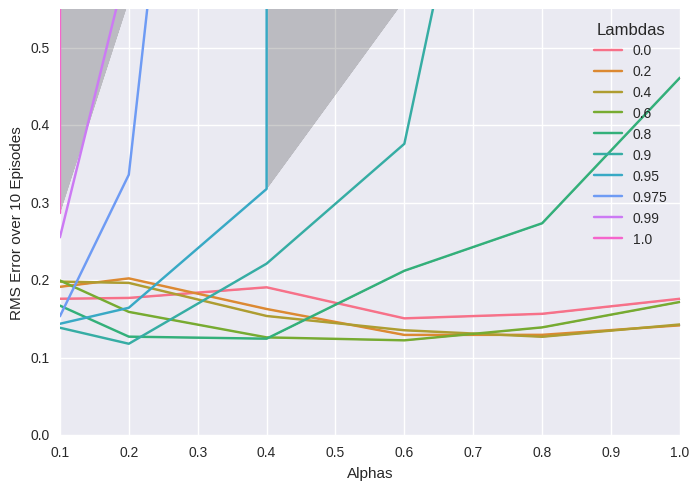

In [4]:
%matplotlib inline

import seaborn
import pickle


with open('ep_errors', 'rb') as f:
    all_agent_ep_error = pickle.load(f)

plot = seaborn.tsplot(data=all_agent_ep_error, time=alphas, legend=True, condition=lambdas)
plot.legend(title='Lambdas')
plot.set_ylabel("RMS Error over " + str(nb_episodes) + " Episodes")
plot.set_xlabel("Alphas")
plot.set_ylim(0, 0.55)